## Load LLaVA-Instruct-150K dataset

Sample:
```json
{
    "id": "000000033471",
    "image": "000000033471.jpg",
    "conversations": [
      {
        "from": "human",
        "value": "<image>\nWhat are the colors of the bus in the image?"
      },
      {
        "from": "gpt",
        "value": "The bus in the image is white and red."
      },
      {
        "from": "human",
        "value": "What feature can be seen on the back of the bus?"
      },
      {
        "from": "gpt",
        "value": "The back of the bus features an advertisement."
      },
      {
        "from": "human",
        "value": "Is the bus driving down the street or pulled off to the side?"
      },
      {
        "from": "gpt",
        "value": "The bus is driving down the street, which is crowded with people and other vehicles."
      }
    ]
}
```


In [1]:
from datasets import load_dataset
!wget -O llava_instruct_150k.json https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json?download=true
llava150k_dataset = load_dataset("json", data_files=["./llava_instruct_150k.json"],split="train")
# download images
image_urls = {
    "coco2017_train": "http://images.cocodataset.org/zips/train2017.zip",     # coco 2017 train
    "textvqa_train_val": "https://dl.fbaipublicfiles.com/textvqa/images/train_val_images.zip",
    "":"https://downloads.cs.stanford.edu/nlp/data/gqa/images.zip"
}
image_folder = "./images"
print(llava150k_dataset[0])
llava150k_dataset

--2025-11-01 11:02:36--  https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_150k.json?download=true
Resolving huggingface.co (huggingface.co)... 104.244.46.185, 2a03:2880:f10d:183:face:b00c:0:25de
Connecting to huggingface.co (huggingface.co)|104.244.46.185|:443... ^C


Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [ ]:
# use wget to download images
!wget -O /tmp/coco2017_train.zip {image_urls["coco2017_train"]}
# !wget -O /tmp/textvqa_train_val.zip {image_urls["textvqa_train_val"]}
# unzip
!mkdir -p {image_folder}
!unzip -q /tmp/coco2017_train.zip -d {image_folder}
# !unzip -q /tmp/textvqa_train_val.zip -d {image_folder}

## Filter llava150k_dataset to ensure all images exist, and filter examples with color words (not sensitive to case)

In [ ]:
import os
color_words = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "gray", "black", "white", "cyan"]
# Get downloaded image paths
downloaded_images = {}  # image file name -> image path
for root, dirs, files in os.walk(image_folder):
    for file in files:
        downloaded_images[file] = os.path.join(root, file)

def check_image_exists(image_path):
    return image_path in downloaded_images

def check_color_word_exist(example):
    conversation_str = str(example["conversations"])
    return any(word in conversation_str.lower() for word in color_words)

# Apply the filter
filtered_dataset = llava150k_dataset.filter(lambda example: check_image_exists( example["image"]))
print(len(filtered_dataset))
# Then filter examples with color words (not sensitive to case)
# Apply color word filter
filtered_dataset = filtered_dataset.filter(lambda example: check_color_word_exist(example))

In [ ]:
print(len(filtered_dataset))

In [ ]:
def process_example(example):
    """
    Process example to add image path and init message format.
    """
    example["image"] = downloaded_images[example["image"]]  # replace image file name with image path
    example["message"] = [  # Init message is image. TODO: 确认多轮对话只需要输入一次图片。 See https://hugging-face.cn/docs/transformers/model_doc/qwen2_5_vl
        {
            "role": "user",
            "content": [{"type": "image"}]
        }
    ]
    for i in range(0,len(example["conversations"]),2):
        if any(word in example["conversations"][i+1]["value"].lower() for word in color_words):    # If the answer contains color word, save Q-A pair
            example["message"].append({
                "role": "user",
                "content": [{"type": "text", "text": example["conversations"][i]["value"].replace("<image>\n","")}]
            })
            example["message"].append({
                "role": "assistant",
                "content": [{"type": "text", "text": example["conversations"][i+1]["value"]}]
            })
        
    return example
filtered_dataset = filtered_dataset.map(process_example)
filtered_dataset.save_to_disk("./color_150k")


In [ ]:
filtered_dataset[0]

## Output qwen CVD format

In [ ]:
# !pip install colour-science
from colour.blindness import matrix_cvd_Machado2009
from PIL import Image
import numpy as np

def RGB_to_sRGB(RGB):
    """RGB to sRGB, value 0.0-1.0(NOT 0-255)"""
    sRGB = np.ones_like(RGB)
    mask = RGB > 0.0031308
    sRGB[~mask] = 12.92*RGB[~mask]
    sRGB[mask] = 1.055 * RGB[mask]**(1 / 2.4) - 0.055
    return sRGB

def sRGB_to_RGB(srgb_img):
    """ Gamma correction of sRGB photo from camera  
        value 0.0-1.0(NOT 0-255)
    Ref: http://brucelindbloom.com/Eqn_RGB_to_XYZ.html 
    """
    RGB = np.ones_like(srgb_img)
    mask = srgb_img < 0.04045
    RGB[mask] = srgb_img[mask]/12.92
    RGB[~mask] = ((srgb_img[~mask]+0.055)/1.055)**2.4
    return RGB

def im_dot(H_mat,im):
    """input: h*w*3, 0.0-1.0 np array"""
    h,w,d = im.shape
    im = sRGB_to_RGB(im)  # convert to RGB, value 0.0-1.0
    im1 = im.reshape(-1,d)
    im_dst1 = im1 @ H_mat.T
    # im_dst1 = cvd_simulation_tritran(im1)
    im_dst = im_dst1.reshape(h,w,d)
    im_dst = RGB_to_sRGB(im_dst)  # convert to sRGB, value 0.0-1.0
    im_dst[im_dst>1] = 1.
    im_dst[im_dst<0] = 0.
    return im_dst
class cvdSimulateNetMarchado():
    def __init__(self,cvd_type="Deuteranomaly",severity=1.0):
        """ 模拟人眼对颜色的感知.
        Args:
            cvd_type (str, optional): 色盲类型. Defaults to "Deuteranomaly". Protanomaly, Deuteranomaly
            severity (float, optional): 色盲 Severity. Defaults to 1.0.
        """
        self.cvd_type = cvd_type
        self.mat = matrix_cvd_Machado2009(cvd_type, severity)
    
    def __call__(self,im):
        """
        input: h*w*3, Image
        output: PIL Image
        """
        if isinstance(im,Image.Image):
            im = np.array(im)/255.
        np_out = im_dot(self.mat,im)
        out = Image.fromarray((np_out*255).astype(np.uint8))
        return out
my_observer = cvdSimulateNetMarchado(cvd_type="Deuteranomaly",severity=0.5)

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [1]:
import os
color_words = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "brown", "gray", "black", "white", "cyan"]
SYS_PROMPT = """ You are a color blind with limited perception on image. 
However, you can still guess the color from your experience. """
image_folder = "/root/autodl-tmp/images/train2017"
# Get downloaded image paths
downloaded_images = {}  # image file name -> image path
import multiprocessing as mp
from functools import partial

# 收集所有文件路径
file_paths = []
for root, dirs, files in os.walk(image_folder):
    for file in files:
        file_path = os.path.join(root, file)
        file_paths.append(file_path)
        downloaded_images[file] = file_path


In [2]:
from datasets import load_dataset, load_from_disk
llava150k_dataset = load_dataset("json", data_files=["/root/autodl-tmp/llava_instruct_150k.json"],split="train")
image_folder = "/root/autodl-tmp/images/train2017"
def check_image_exists(image_path):
    return image_path in downloaded_images

def check_color_word_exist(example):
    conversation_str = str(example["conversations"])
    conversation_set = set(conversation_str.lower().split())
    return any(word in conversation_set for word in color_words)

# Apply the filter
filtered_dataset = llava150k_dataset.filter(lambda example: check_image_exists( example["image"]))
print(len(filtered_dataset))
# Then filter examples with color words (not sensitive to case)
# Apply color word filter
filtered_dataset = filtered_dataset.filter(lambda example: check_color_word_exist(example))
print(len(filtered_dataset))
def process_example(example):
    """
    Process example to add image path and init message format.
    """

    example["image"] = downloaded_images[example["image"]]  # replace image file name with image path
    example["messages"] = [  # Init message is image. TODO: 确认多轮对话只需要输入一次图片。 See https://hugging-face.cn/docs/transformers/model_doc/qwen2_5_vl
        {
            "role": "system",
            "content": SYS_PROMPT,
        },
        {
            "role": "user",
            "content":"<image>\n",
            "images" : [example["image"]]
        }
    ]
    for i in range(0,len(example["conversations"]),2):# 故意混入一些非颜色词的QA
        if any(word in example["conversations"][i+1]["value"].lower() for word in color_words):    # If the answer contains color word, save Q-A pair
            user_message = {
                "role": "user",
                "content":example["conversations"][i]["value"].replace("<image>","")+"(pay attention to color especially)"
            }
            example["messages"].append(user_message)
            example["messages"].append({
                "role": "assistant",
                "content": example["conversations"][i+1]["value"]
            })
    return example
    
# filtered_dataset_o = filtered_dataset.map(process_example)
# # 将数据集转换为 JSON 格式
# filtered_dataset_o.to_json(f"color_150k.json", orient="records", lines=True)

# 不采用map, 直接遍历
filtered_dataset_o = [process_example(example) for example in filtered_dataset]
import json
with open(f"color_150k.json", "w", encoding="utf-8") as f:
    json.dump(filtered_dataset_o, f, ensure_ascii=False, indent=4)

157712
47646


{'id': '000000033471', 'image': '/root/autodl-tmp/images/train2017/000000033471.jpg', 'conversations': [{'from': 'human', 'value': '<image>\nWhat are the colors of the bus in the image?'}, {'from': 'gpt', 'value': 'The bus in the image is white and red.'}, {'from': 'human', 'value': 'What feature can be seen on the back of the bus?'}, {'from': 'gpt', 'value': 'The back of the bus features an advertisement.'}, {'from': 'human', 'value': 'Is the bus driving down the street or pulled off to the side?'}, {'from': 'gpt', 'value': 'The bus is driving down the street, which is crowded with people and other vehicles.'}], 'messages': [{'role': 'system', 'content': ' You are a color blind with limited perception on image. \nHowever, you can still guess the color from your experience. '}, {'role': 'user', 'content': '<image>\n', 'images': ['/root/autodl-tmp/images/train2017/000000033471.jpg']}, {'role': 'user', 'content': '\nWhat are the colors of the bus in the image?(pay attention to color espe

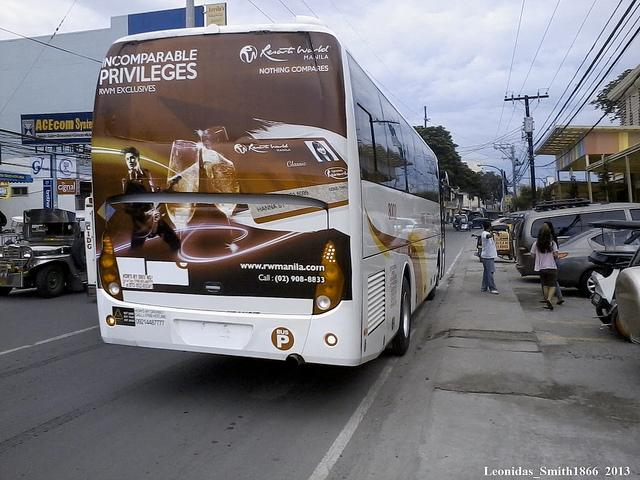

In [3]:
from PIL import Image
imgtmp = Image.open(filtered_dataset_o[0]["image"])
print(filtered_dataset_o[0])
imgtmp

## Final Sample
Sample:
```json
{
    "id": "123456",
    "image": "'/root/autodl-tmp/images/train2017/000000033471.jpg",
    "conversations": [
        {"from": "human", "value": "<image>\nWhat are the colors of the bus in the image?"}, 
        {"from": "gpt", "value": "The bus in the image is white and red."},
    ],
    "messages": [
        {"role": "system", "content": " You are a color blind with limited perception on image. \nHowever, you can still guess the color from your experience. "}, 
        {"role": "user", "content": "<image>\n", "images": ["/root/autodl-tmp/images/train2017/000000033471.jpg"]}, 
        {"role": "user", "content": "\nWhat are the colors of the bus in the image?(pay attention to color especially)"}, 
        {"role": "assistant", "content": "The bus in the image is white and red."}
    ]
}
```

# Train Usage
Download Model With HF-MIRROR
```
export HF_ENDPOINT=https://hf-mirror.com
huggingface-cli download --resume-download Qwen/Qwen3-VL-4B-Instruct --local-dir /path/to
git clone https://github.com/QwenLM/Qwen3-VL.git
```
Modify `data/__init__.py`:
```python
CVD_DATASET = {
    "annotation_path": "/data/color_150k.json",
    "data_path": "/data/images/coco2017_train/train2017",
}

data_dict = {
    "cvd_dataset": CVD_DATASET,
    ...,  # existing dataset
}
```
AAA
```bash
#!/bin/bash
# Complete QwenVL Training Launch Script with Full Parameter Documentation

# ======================
# Distributed Configuration
# ======================
MASTER_ADDR="127.0.0.1"                     # [Required] Master node IP for multi-GPU training
MASTER_PORT=$(shuf -i 20000-29999 -n 1)     # Random port to avoid conflicts
NPROC_PER_NODE=$(nvidia-smi --list-gpus | wc -l)  # Automatically detects available GPUs

# ======================
# Path Configuration
# ======================
MODEL_PATH="/autodl-tmp/"  # [ModelArguments] Pretrained model path
OUTPUT_DIR="./checkpoints"                   # Directory for saving checkpoints
CACHE_DIR="./cache"                          # [TrainingArguments] Cache directory for models

# ======================
# Model Configuration
# ======================
DATASETS="cvd_dataset%100"                  # [DataArguments] Dataset with sampling rate

# ======================
# Training Hyperparameters
# ======================
torchrun --nproc_per_node=$NPROC_PER_NODE \
         --master_addr=$MASTER_ADDR \
         --master_port=$MASTER_PORT \
         qwenvl/train/train_qwen.py \
         # Core Arguments
         --model_name_or_path $MODEL_PATH \  # [ModelArguments] Model identifier
         --tune_mm_llm False \                # [TrainingArguments] Train LLM or not
         --tune_mm_vision True \            # [TrainingArguments] Train VIT or not
         --tune_mm_mlp True \               # [TrainingArguments] Train MLP or not
         --dataset_use $DATASETS \           # [DataArguments] Dataset specification
         --output_dir $OUTPUT_DIR \          # Output directory for checkpoints
         --cache_dir $CACHE_DIR \            # [TrainingArguments] Model cache location
         
         # Precision & Memory
         --bf16 \                            # Use bfloat16 precision (Ampere+ GPUs)
         --per_device_train_batch_size 4 \   # Batch size per GPU
         --gradient_accumulation_steps 4 \   # Effective batch size multiplier
         
         # Learning Rate Configuration
         --learning_rate 2e-7 \              # Base learning rate
         --mm_projector_lr 1e-5 \            # [TrainingArguments] Projector-specific LR
         --vision_tower_lr 1e-6 \            # [TrainingArguments] Vision encoder LR
         --optim adamw_torch \               # [TrainingArguments] Optimizer selection
         
         # Sequence Configuration
         --model_max_length 2048 \           # [TrainingArguments] Max sequence length
         --data_flatten True \               # [DataArguments] Concatenate batch sequences
         --data_packing True \               # [DataArguments] Using packing data
         
         # Image Processing
         --max_pixels 576\*28\*28 \               # [DataArguments] Max image pixels (H*W) for image
         --min_pixels 16\*28\*28 \                # [DataArguments] Min image pixels for image
         # Video Processing
         --video_fps 2 \                          # [DataArguments] video fps
         --video_max_frames 8 \                   # [DataArguments] Max frames per video
         --video_min_frames 4 \                   # [DataArguments] Min frames per video
         --video_max_pixels 1664\*28\*28 \        # [DataArguments] Max pixels per video
         --video_min_pixels 256\*28\*28 \         # [DataArguments] Min pixels per video
         
         # Training Schedule
         --num_train_epochs 2 \              # Total training epochs
         --warmup_ratio 0.03 \               # LR warmup proportion
         --lr_scheduler_type "cosine" \      # Learning rate schedule
         --weight_decay 0.01 \               # L2 regularization strength
         
         # Logging & Checkpoints
         --logging_steps 10 \               # Log metrics interval
         --save_steps 500 \                 # Checkpoint save interval
         --save_total_limit 3 \             # Max checkpoints to keep

         # Lora Config
         --lora_enable False \                 # [TrainingArguments] Enable LoRA

         # Advanced Options
         --deepspeed zero3.json \           # DeepSpeed configuration
```